In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
import torch.cuda as cuda
from torch.autograd import Variable
import math

from utils import create_dataloader,train
from dataset import EEG
import wandb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
import sys


sys.path.append(os.path.abspath(os.path.join('..')))
# Now do your import
from config import *

c:\Users\Pongk\.virtualenvs\EEG-python-MGW7v3UV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model import ConvNet,CNN2D,ConvNet2
from torchsummary import summary
net = ConvNet2().cuda()
online_path = "/Users/Pongk/Desktop/Work/mi-project/EEG-python/Training/save_weight/S18_newConv_irr_-2-5_8-13_2ch/0.6711_S18_newConv_irr_-2-5_8-13_2ch_0.6711_65.3846.pth"

net.load_state_dict(torch.load(online_path))

<All keys matched successfully>

In [3]:
# home directory + datasets folder
path = RECORED_PATH
#subject to run
runs = [14,15,16,17,18,19]
subjects = [18]
#recorded eeg class
eeg = EEG(path, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter 
X,y = eeg.raw_preprocess(raw)
X = eeg.apply_baseline(X)
# iir_param = dict(order=5, ftype='butter', output='sos')
# raw=raw.notch_filter([50])
# #raw=raw.filter(8,14,method = 'iir',iir_params=iir_param,phase='zero')
# raw = raw.filter(8,14, method='fir', verbose=20)
print("Filter done")

# epochs=eeg.epochs(raw,tmin=-3,tmax=5,baseline=(-3,0))
# #X = X[:, :,np.newaxis,:]
# X, y = eeg.get_X_y(epochs)
#(250*5) 
#X = X[:,:,(250*3):]
#fixation_X = X[:,:,(250*1):(250*3)]
#imagine_X = X[:,:,(250*8):(250*13)]


/Users/Pongk/Desktop/Work/mi-project/EEG-python/dataset/recorded_EEG
Raw done
Filter done


In [4]:
batch_size = 1750
test_loader = create_dataloader(X, y, batch_size=batch_size)

num_step =math.ceil(len(test_loader.dataset) / batch_size)

In [5]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        #loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        for i in range(predicted.shape[0]):
            
            if predicted[i] == classes.data[i]:
                correct += 1
            
        #correct += (predicted == classes.data).sum()
        
        iterations += 1

    #valid_loss.append(loss/iterations)
    #correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))

 Val Acc: 47.5000


In [6]:
print(predicted)
print(classes.data.cpu().numpy())
y_true = classes.data.cpu().numpy()
y_pred = y_pred=predicted.cpu().numpy()

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
[0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1
 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 0 0 0 1 1 1 0 0 1]


In [7]:
confusion_matrix(y_true, y_pred)

array([[45, 15],
       [48, 12]], dtype=int64)

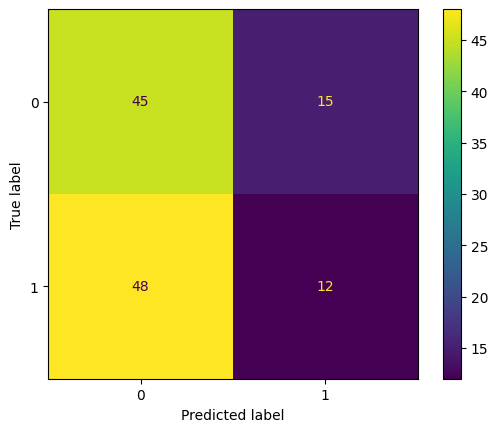

In [8]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)